In [1]:
# Import candidate models
from doubt import Boot, QuantileRegressor, QuantileRegressionForest
from sklearn.linear_model import (LinearRegression, PoissonRegressor, 
                                  GammaRegressor, HuberRegressor, 
                                  SGDRegressor)
from sklearn.ensemble import RandomForestRegressor

# Import datasets
from doubt.datasets import (Airfoil, Blog, Concrete, CPU, 
                            FacebookComments, FishBioconcentration,
                            FishToxicity, ForestFire, NewTaipeiHousing,
                            PowerPlant, Protein, Servo,
                            SpaceShuttle, Yacht)

# Import external libraries
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from scipy.stats import ks_2samp, entropy, kruskal
import matplotlib.pyplot as plt; plt.style.use('ggplot')

# Import internal classes
from distributions import DistributionShift
from src.psi import psi

In [2]:
dataset_classes = [Airfoil, Concrete,
                   FishToxicity, ForestFire, NewTaipeiHousing,
                   PowerPlant, Protein, Servo]

In [3]:
def monitoring_plot(dataset, method: str):    
    # Load the dataset and split it
    X_train, X_test, y_train, y_test = dataset().split(test_size=0.3, random_seed=4242)
    
    # Initialise the shifter
    shifter = DistributionShift()
    shifter.fit(X_train)
    
    # Initialise plot
    plt.figure(figsize=(14, 7))
    plt.title(f'Monitoring plot using "{method}" for the {dataset.__name__} dataset under feature drift')
    plt.xlabel('Number of standard deviations shifted')
    plt.ylabel(f'{method} value')

    # Fit the regressor
    if method == 'uncertainty':
        regressor = Boot(LinearRegression())
        regressor.fit(X_train, y_train, n_boots=10)

    xx = range(-5, 6)
    for col in trange(X_train.shape[1]):
        values = []
        for std in xx:
            shifter.set_params(param=std, cols=[col])
            new_X_test = shifter.transform(X_test)
            
            if abs(std) < 1e-5:
                assert (X_test == new_X_test).all()
            
            if method == 'uncertainty':
                _, intervals = regressor.predict(new_X_test, uncertainty=0.05, n_boots=10)
                value = np.mean(intervals[:, 1] - intervals[:, 0])
                
            elif method == 'psi':
                value = sum(psi(X_train[:, c], new_X_test[:, c]) for c in range(X_train.shape[1]))
                
            elif method == 'ks':
                value = sum(ks_2samp(X_train[:, c], new_X_test[:, c]).statistic for c in range(X_train.shape[1]))
                
            elif method == 'kw':
                value = sum(kruskal(X_train[:, c], new_X_test[:, c]).statistic for c in range(X_train.shape[1]))
                
            elif method == 'kl':
                orig = np.random.choice(X_train[:, col], size=X_test.shape[0])
                new = new_X_test[:, col]
                value = entropy(orig, new) + entropy(new, orig)
            
            values.append(value)

        plt.plot(xx, values, label=f'Feature {col}', marker='x')
        
    plt.legend()
    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

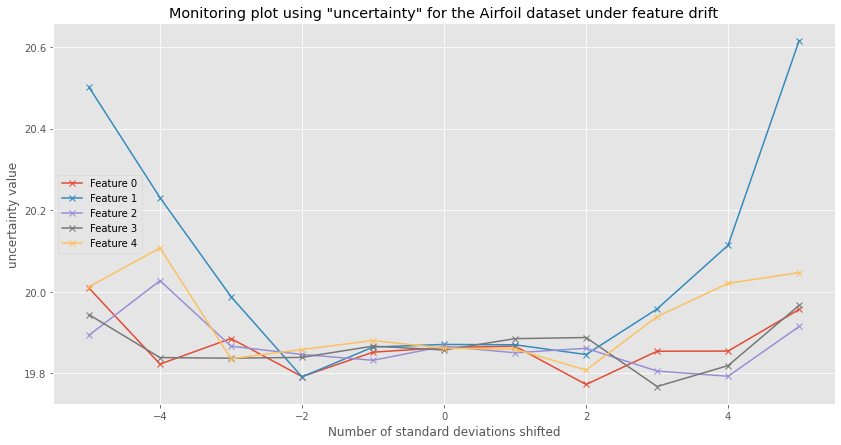

  0%|          | 0/8 [00:00<?, ?it/s]

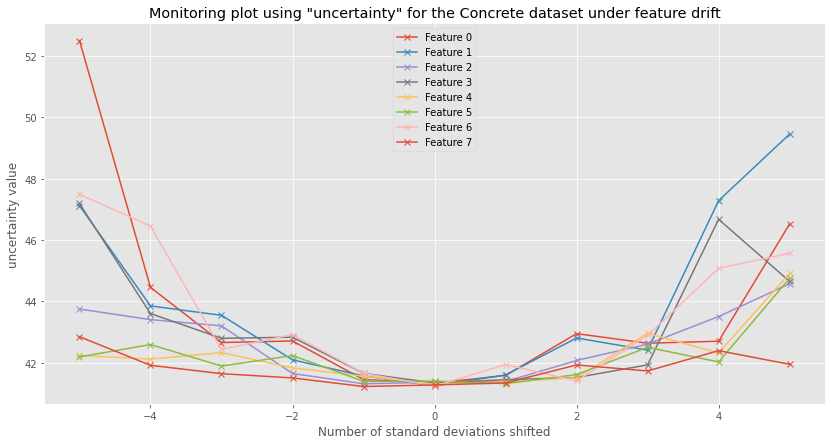

  0%|          | 0/6 [00:00<?, ?it/s]

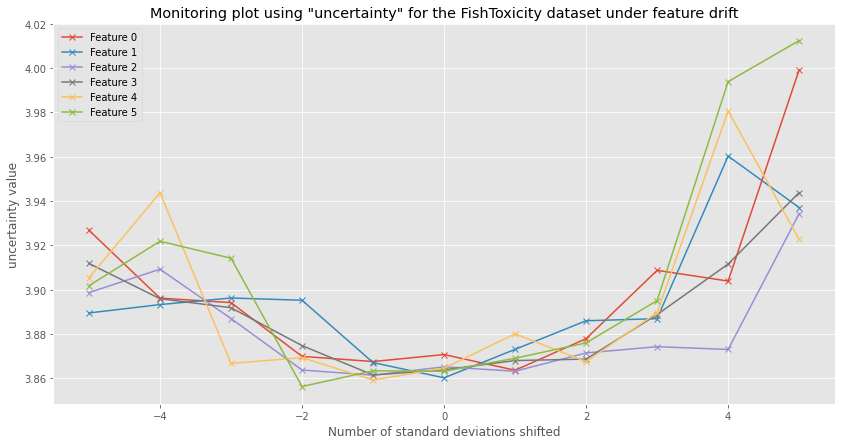

  0%|          | 0/12 [00:00<?, ?it/s]

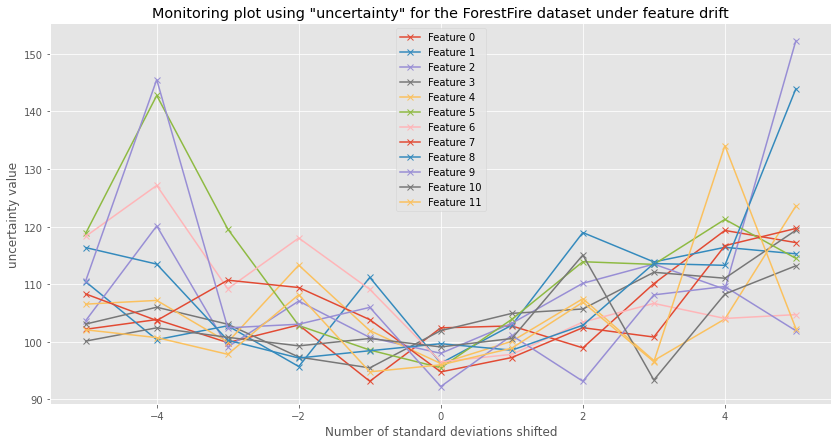

  0%|          | 0/6 [00:00<?, ?it/s]

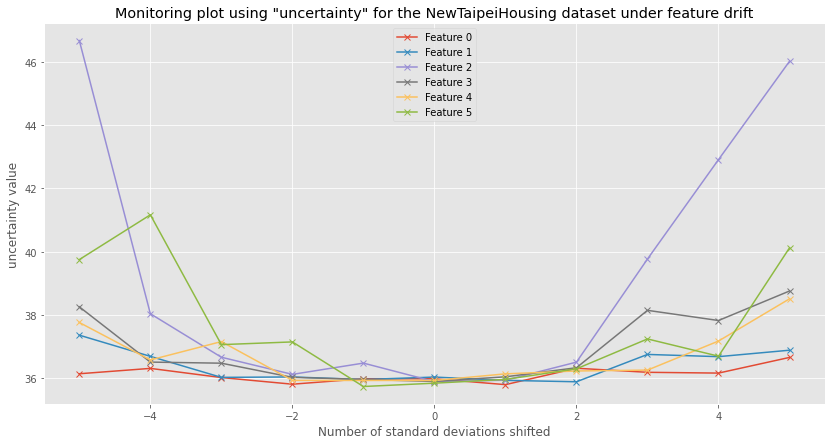

  0%|          | 0/4 [00:00<?, ?it/s]

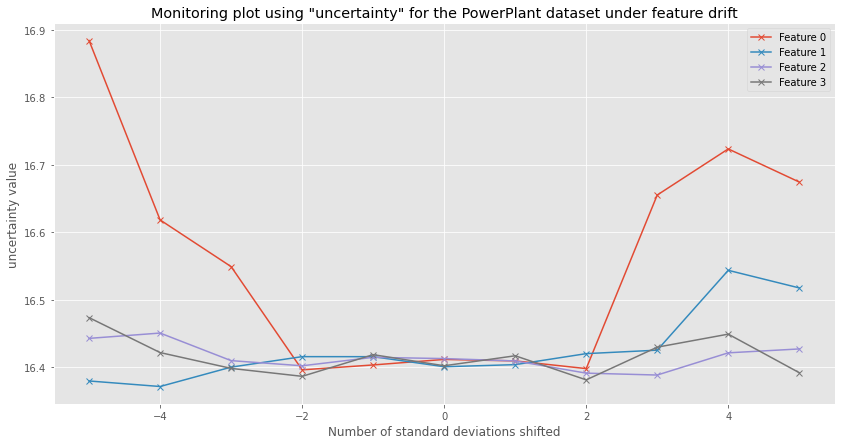

  0%|          | 0/9 [00:00<?, ?it/s]

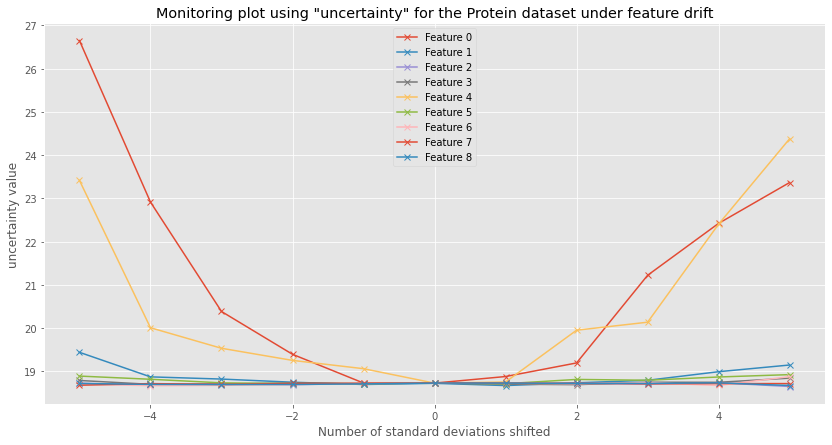

  0%|          | 0/4 [00:00<?, ?it/s]

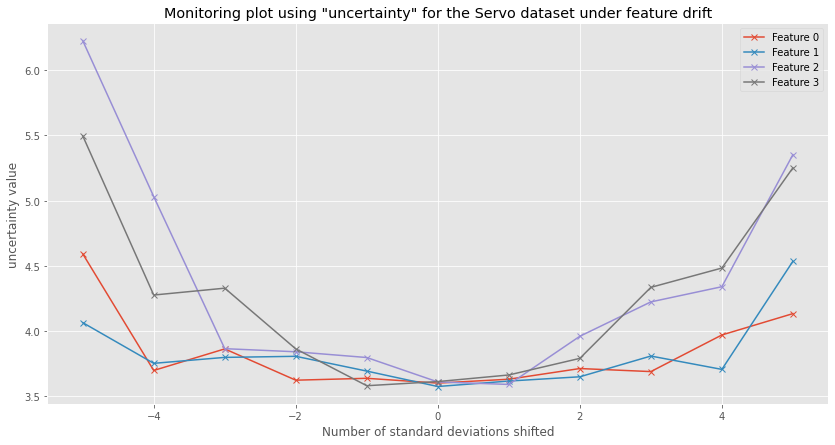

CPU times: user 2min 5s, sys: 23.2 s, total: 2min 28s
Wall time: 47.8 s


In [4]:
%%time
for dataset in dataset_classes:
    monitoring_plot(dataset, 'uncertainty')

  0%|          | 0/5 [00:00<?, ?it/s]

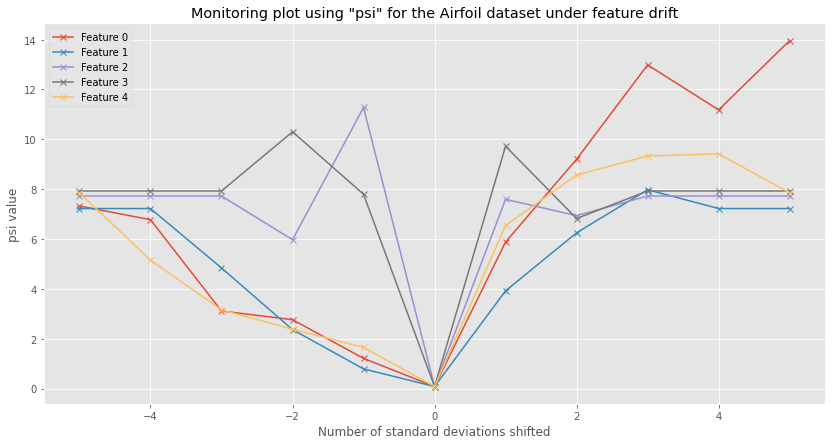

  0%|          | 0/8 [00:00<?, ?it/s]

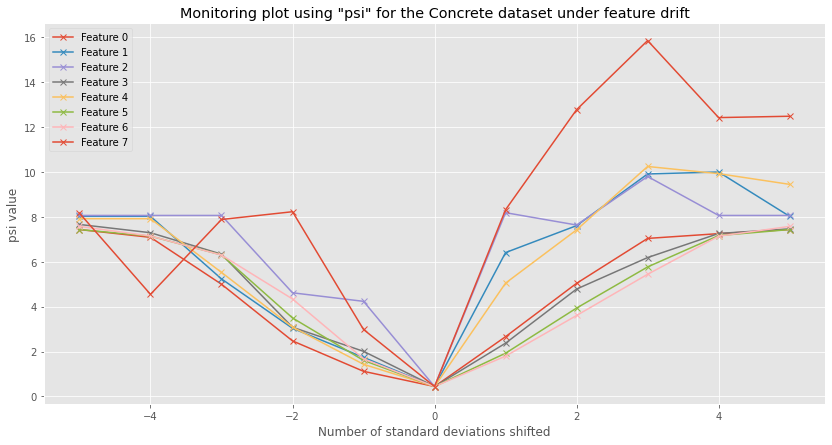

  0%|          | 0/6 [00:00<?, ?it/s]

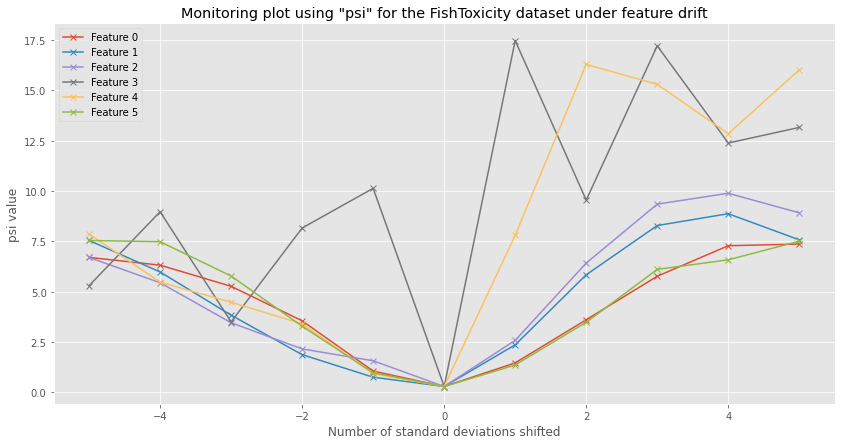

  0%|          | 0/12 [00:00<?, ?it/s]

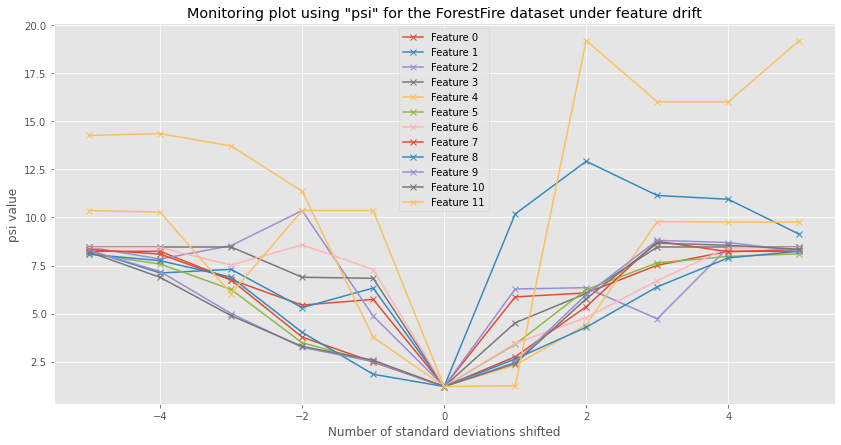

  0%|          | 0/6 [00:00<?, ?it/s]

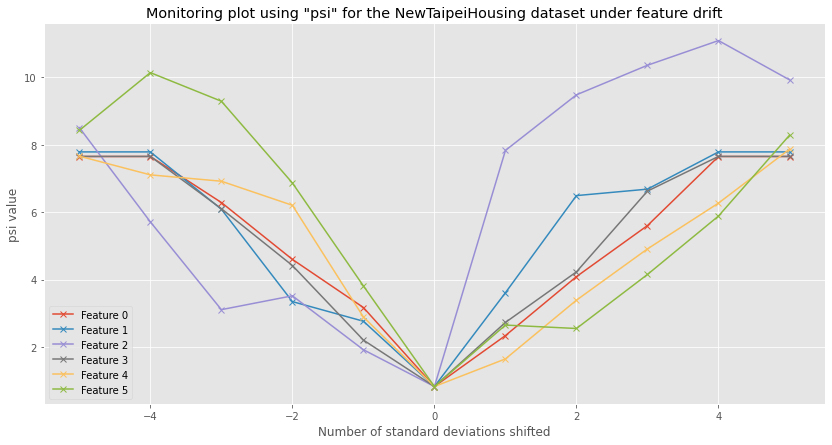

  0%|          | 0/4 [00:00<?, ?it/s]

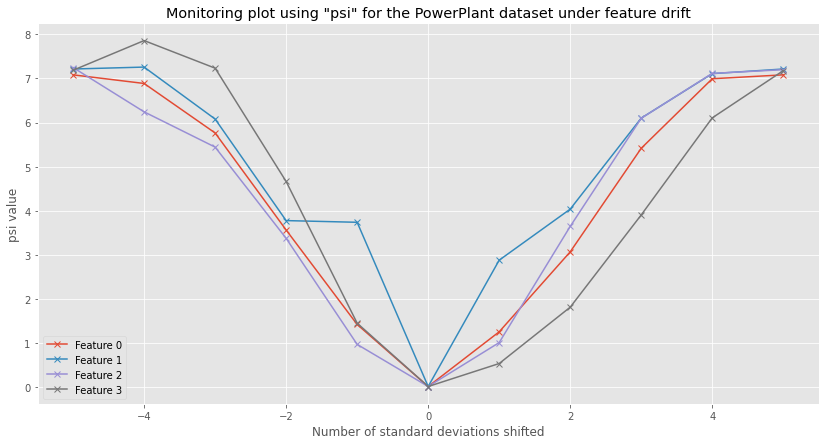

  0%|          | 0/9 [00:00<?, ?it/s]

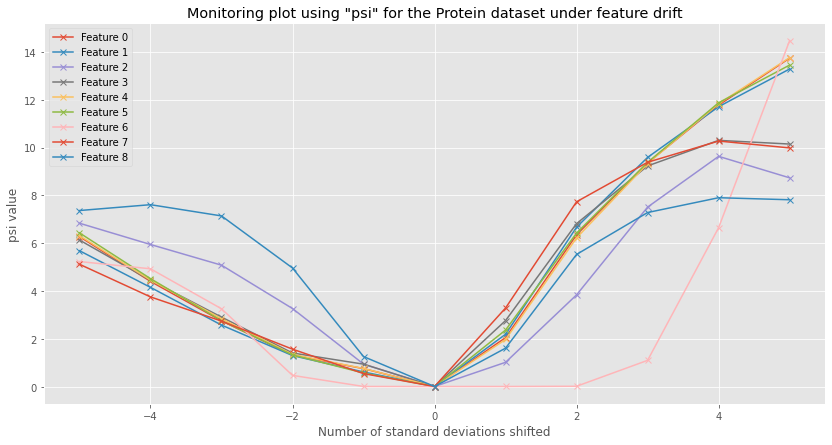

  0%|          | 0/4 [00:00<?, ?it/s]

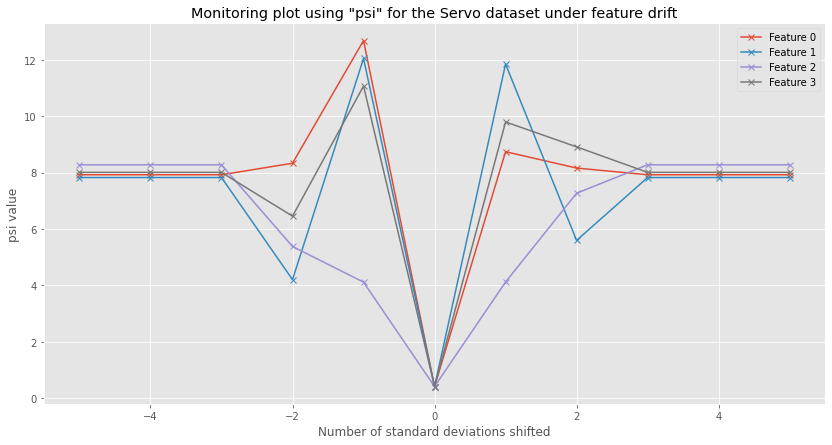

CPU times: user 5.82 s, sys: 142 ms, total: 5.96 s
Wall time: 5.94 s


In [5]:
%%time
for dataset in dataset_classes:
    monitoring_plot(dataset, 'psi')

  0%|          | 0/5 [00:00<?, ?it/s]

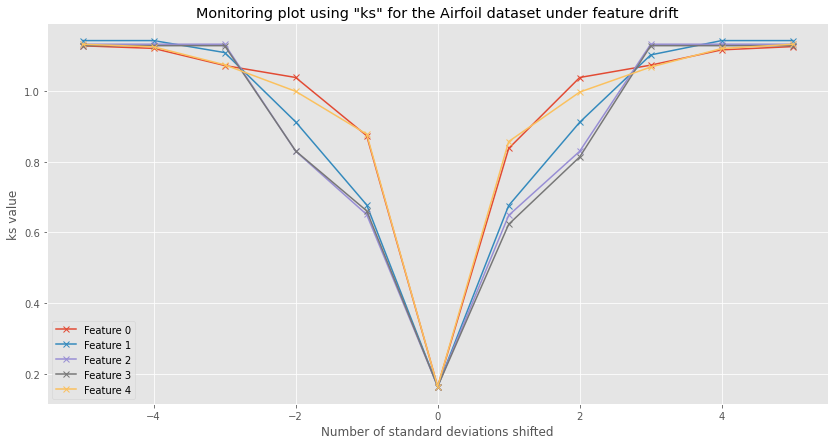

  0%|          | 0/8 [00:00<?, ?it/s]

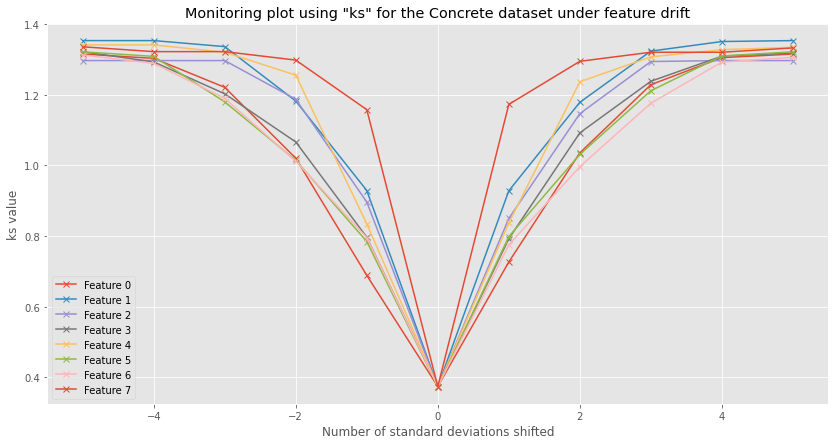

  0%|          | 0/6 [00:00<?, ?it/s]

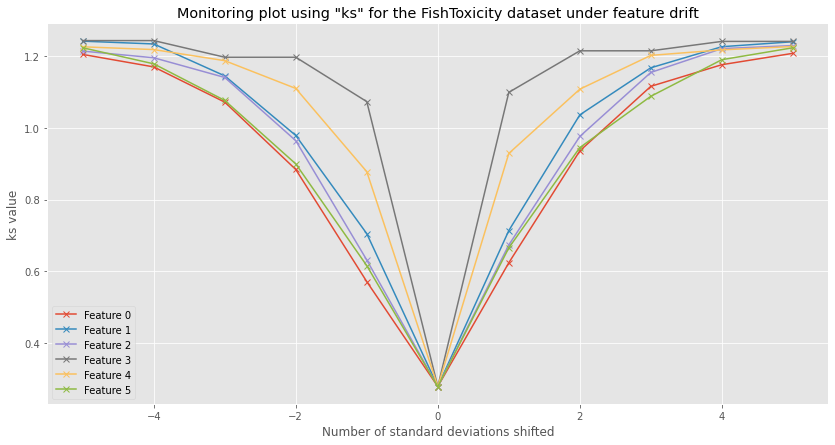

  0%|          | 0/12 [00:00<?, ?it/s]

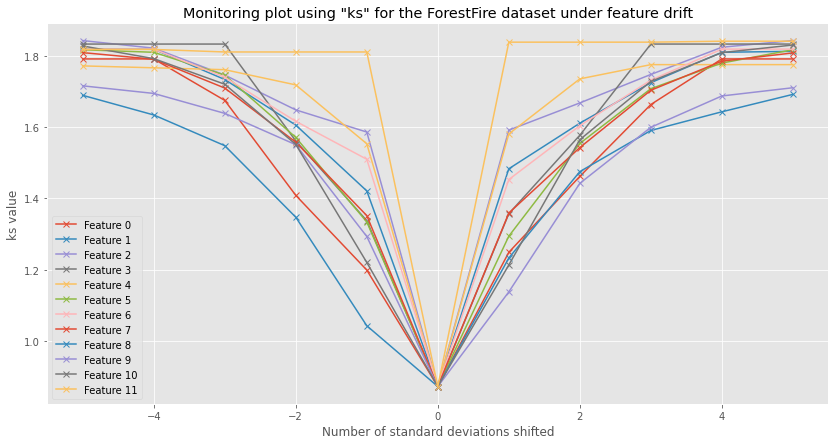

  0%|          | 0/6 [00:00<?, ?it/s]

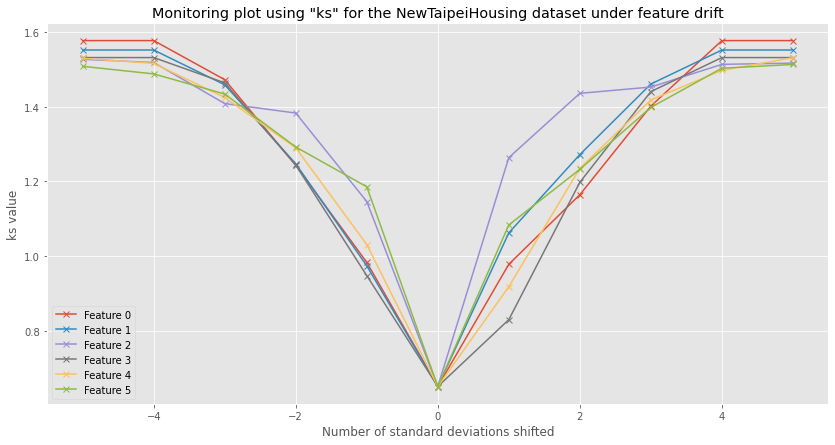

  0%|          | 0/4 [00:00<?, ?it/s]

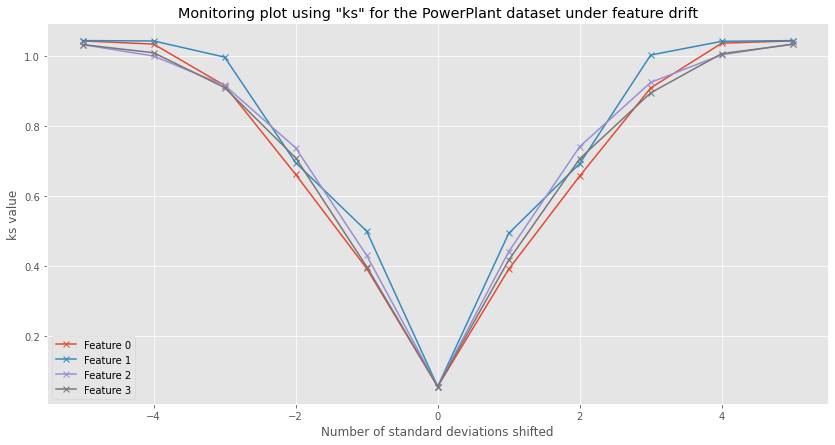

  0%|          | 0/9 [00:00<?, ?it/s]

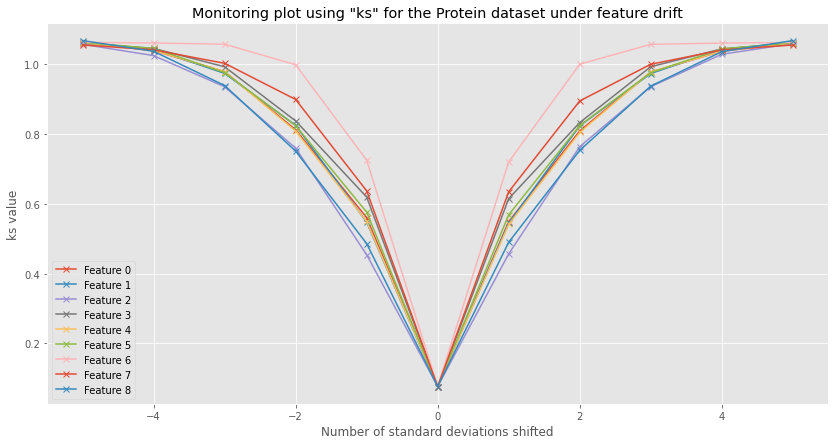

  0%|          | 0/4 [00:00<?, ?it/s]

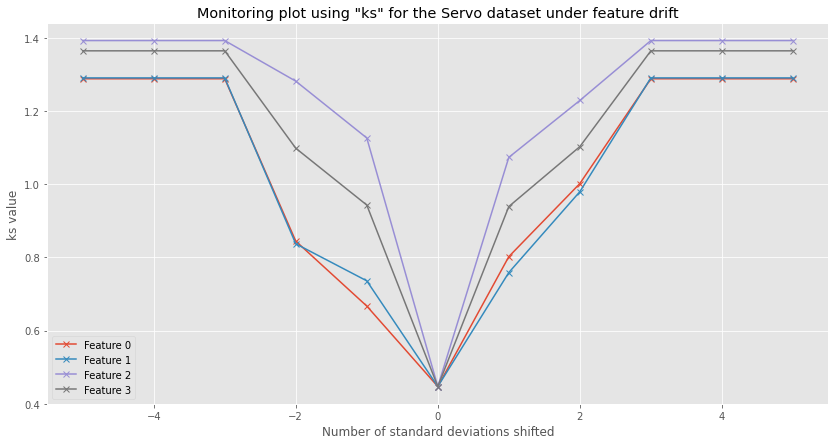

CPU times: user 32.5 s, sys: 490 ms, total: 33 s
Wall time: 33 s


In [6]:
%%time
for dataset in dataset_classes:
    monitoring_plot(dataset, 'ks')

  0%|          | 0/5 [00:00<?, ?it/s]

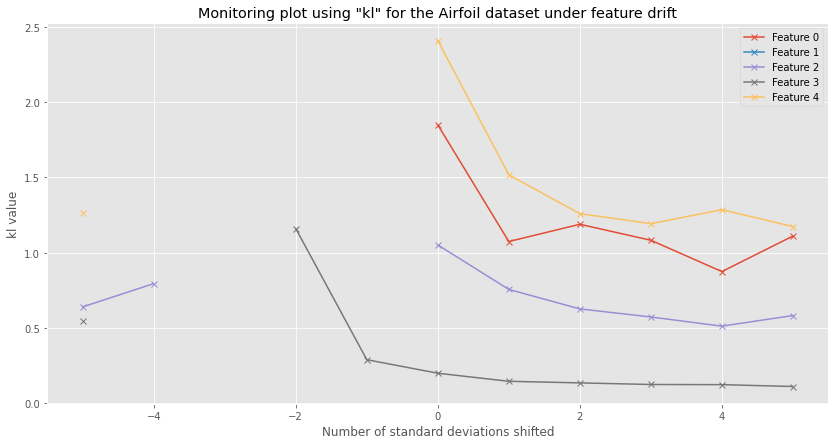

  0%|          | 0/8 [00:00<?, ?it/s]

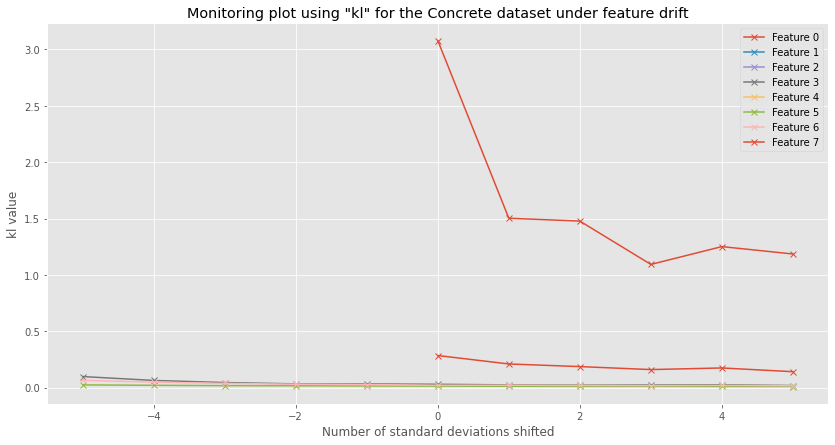

  0%|          | 0/6 [00:00<?, ?it/s]

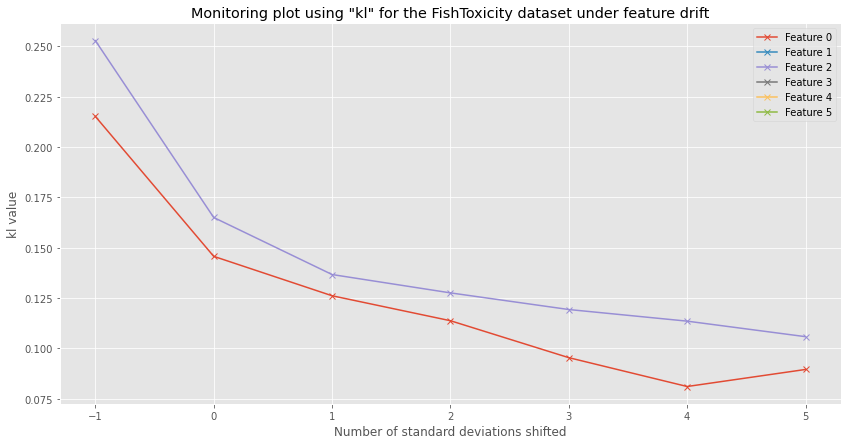

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/saattrupdan/gitsky/monitoring-uncertainty/.venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/Users/saattrupdan/gitsky/monitoring-uncertainty/.venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2758: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)


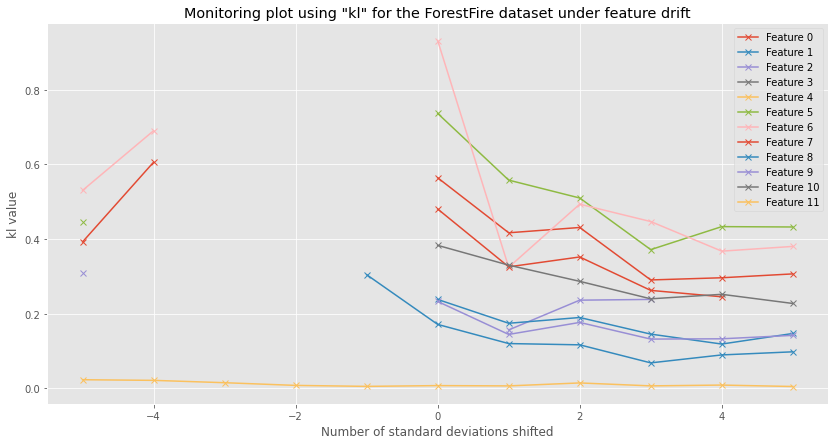

  0%|          | 0/6 [00:00<?, ?it/s]

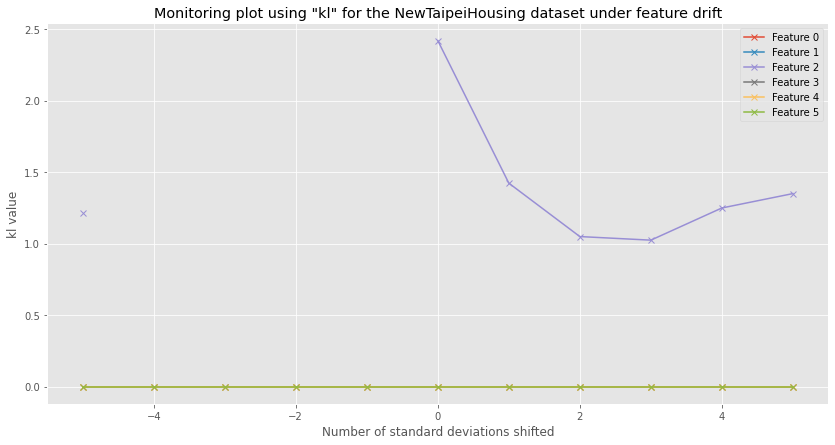

  0%|          | 0/4 [00:00<?, ?it/s]

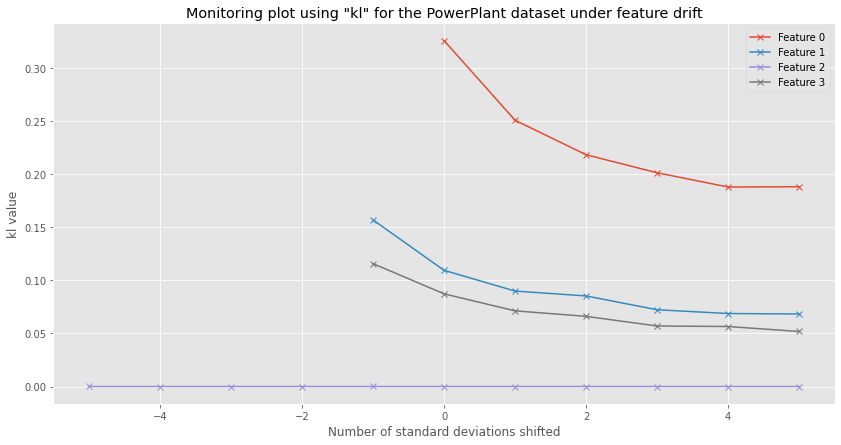

  0%|          | 0/9 [00:00<?, ?it/s]

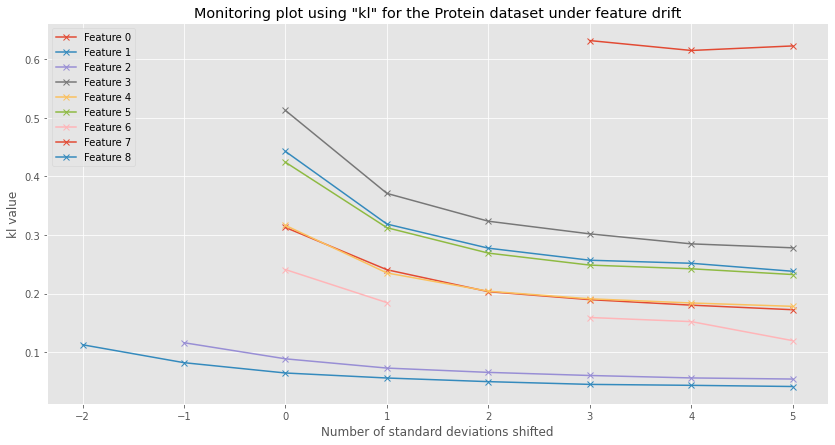

  0%|          | 0/4 [00:00<?, ?it/s]

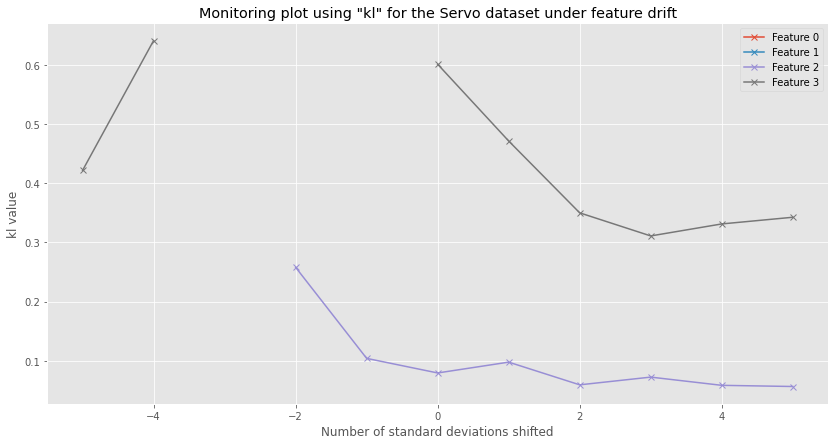

CPU times: user 2.42 s, sys: 129 ms, total: 2.55 s
Wall time: 2.52 s


In [7]:
%%time
for dataset in dataset_classes:
    monitoring_plot(dataset, 'kl')

  0%|          | 0/5 [00:00<?, ?it/s]

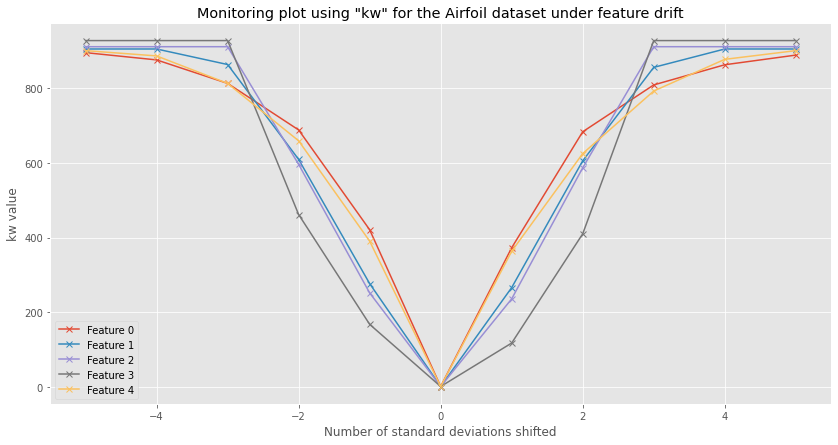

  0%|          | 0/8 [00:00<?, ?it/s]

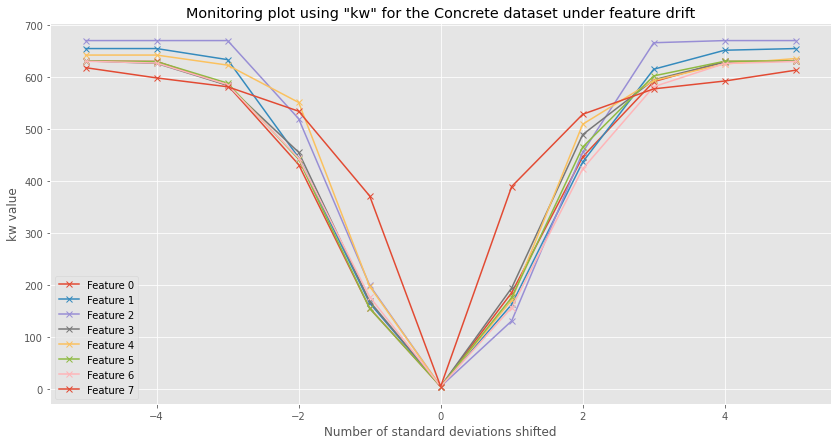

  0%|          | 0/6 [00:00<?, ?it/s]

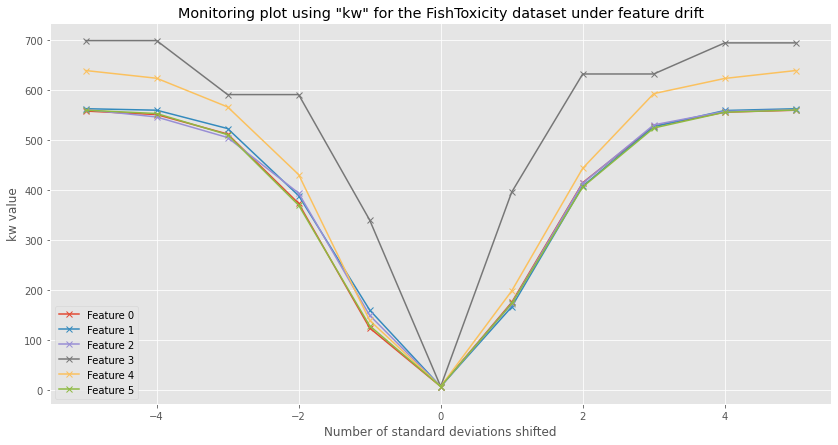

  0%|          | 0/12 [00:00<?, ?it/s]

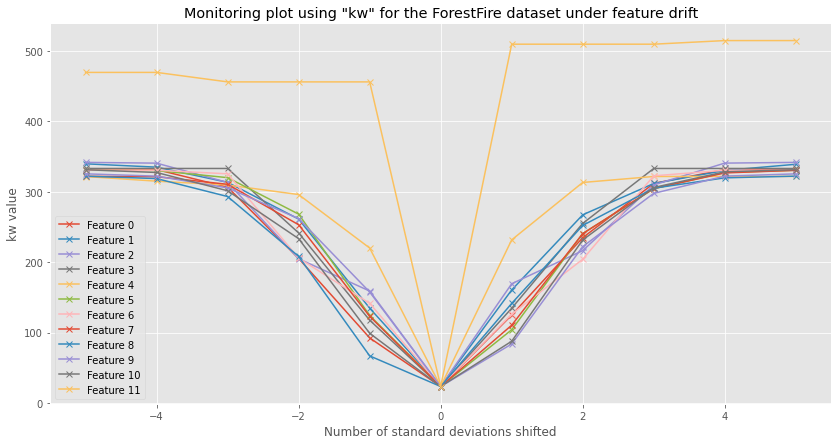

  0%|          | 0/6 [00:00<?, ?it/s]

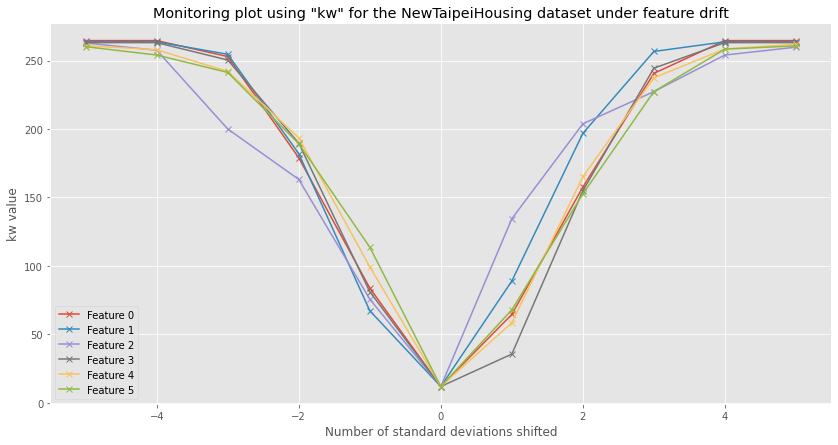

  0%|          | 0/4 [00:00<?, ?it/s]

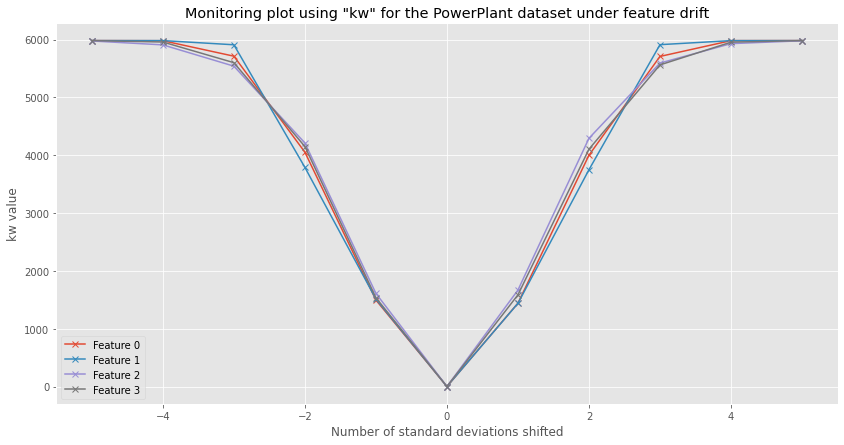

  0%|          | 0/9 [00:00<?, ?it/s]

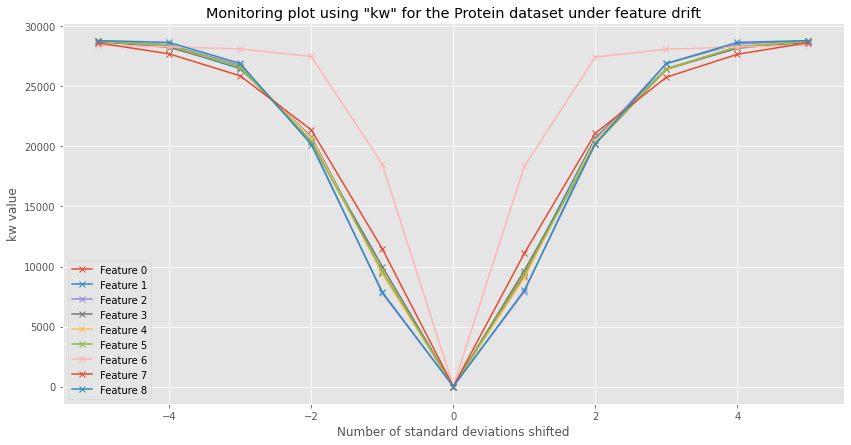

  0%|          | 0/4 [00:00<?, ?it/s]

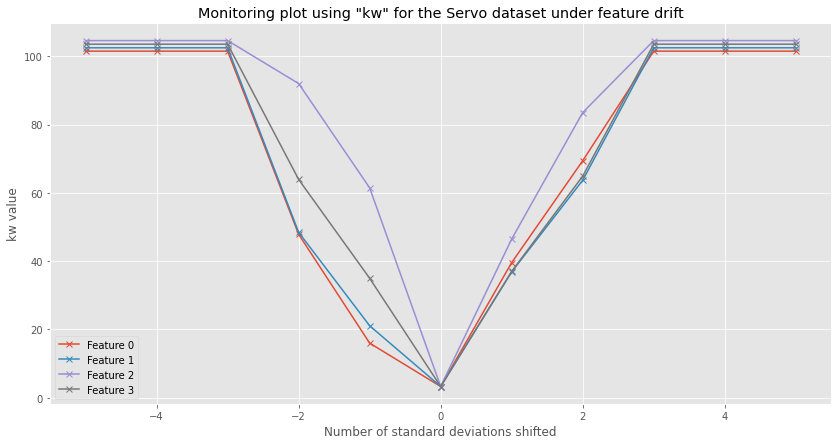

CPU times: user 11.6 s, sys: 247 ms, total: 11.9 s
Wall time: 11.9 s


In [8]:
%%time
for dataset in dataset_classes:
    monitoring_plot(dataset, 'kw')